In [2]:
using Plots, Plots.PlotMeasures, LaTeXStrings, JLD2, FileIO, CPUTime, TickTock, LinearAlgebra, SpecialFunctions, NLsolve, ForwardDiff, DataStructures, Statistics, Distributions, LsqFit

# **Define All the Functions** 

## **The function to search an element closest to a real number in ana array**

In [2]:
function find_closest(A::AbstractArray{T}, b::T) where {T<:Real}
    if length(A) <= 1
        return firstindex(A)
    end

    i = searchsortedfirst(A, b)

    if i == firstindex(A)
        return i
    elseif i > lastindex(A)
        return lastindex(A)
    else
        prev_dist = b - A[i-1]
        next_dist = A[i] - b

        if prev_dist < next_dist
            return i - 1
        else
            return i
        end
    end
end

find_closest (generic function with 1 method)

## **Define the equilibrium fermi function**

In [3]:
@inline function f0( E, T0 )
    
    f0 = 1.0 / ( exp(E/T0) + 1.0 );
    
    return f0 
    
end    

f0 (generic function with 1 method)

## **Define the equilibrium bose function**

In [4]:
@inline function b0( E, T0 )
    
    b0 = 1.0 / ( exp(E/T0) - 1.0 );
    
    return b0 
    
end    

b0 (generic function with 1 method)

## **Define the partial derivative of the equilibrium fermi function**

In [5]:
@inline function d_E_f0( E, T0 )

    d_E_f0 = (1/T0) * f0( E, T0 ) * ( f0( E, T0 ) - 1 );
    
    return d_E_f0 
    
end 

d_E_f0 (generic function with 1 method)

## **Define the $Z_0$ function appearing in the diagonals of the $A$ matrix**

In [6]:
@inline function Z0( E, N_Phonon, Ω_List, λ_List, T0 )

    Z0 = 1.0

    for i = 1:N_Phonon 
    
        Z0 = Z0 - ( ( λ_List[i] * (Ω_List[i])^2 )/(4*pi*(Ω_List[i])*T0) ) * imag( polygamma( 1, (1/2) + im*( (E+Ω_List[i])/(2.0*pi*T0) ) ) - polygamma( 1, (1/2) + im*( (E-Ω_List[i])/(2.0*pi*T0) ) ) );

    end
    
    return Z0 
    
end 

Z0 (generic function with 1 method)

## **Define the function appearing in the diagonals of the $A$ matrix**

In [7]:
@inline function a( E, N_Phonon, Ω_List, λ_List, T0 )

    a  = Z0( E, N_Phonon, Ω_List, λ_List, T0 ) * d_E_f0( E, T0 );
    
    return a 
    
end 

a (generic function with 1 method)

## **Define the function to fill in the elements of the $A$ matrix**

In [8]:
@inline function Fill_A_Total!( A_Total_Mat, ΔE, L, N_Phonon, Ω_List, λ_List, T0 )

    for j = 1 : L
        
        for k = 1 : L
            Ej = j*ΔE;

            if k == j                    
                A_Total_Mat[j,k] = a( Ej, N_Phonon, Ω_List, λ_List, T0 );
            end 

        end            
    end 
    
end      

Fill_A_Total! (generic function with 1 method)

## **Define the function to fill in the elements of the $B$ matrix**

In [9]:
@inline function Fill_B!( B_Mat, ΔE, L, r, Ω, λ, T0 )

    for j = 1 : L
        Ej = j*ΔE;
        
        for k = 1 : L
            Ek = k*ΔE;

            if     k == j - r                    
                B_Mat[j,k] = 0;

            elseif k == j + r
                B_Mat[j,k] = 0;

            elseif k == r - j
                B_Mat[j,k] = 0;

            else                    
                B_Mat[j,k] = (λ*Ω^2) * ( d_E_f0( Ej, T0 ) * d_E_f0( Ek, T0 ) * 4.0 * j * k * ΔE ) / ( ( (j-k)^2 - r^2 ) * ( (j+k)^2 - r^2 ) );

            end 

        end            
    end
     
end      

Fill_B! (generic function with 1 method)

## **Define the prefactor $\alpha(\Omega, T_0) = \pi \left( \frac{\lambda \Omega}{T_0} \right) n_{B}(\Omega)(n_{B}(\Omega)+1)$ that appears in the $C$ and the $D$ matrices**

In [10]:
@inline function α( λ, Ω, T0 )
    
    α = ( (pi*λ*Ω)/T0 ) * b0( Ω, T0 ) * ( b0( Ω, T0 ) + 1);
    
    return α 
    
end 

α (generic function with 1 method)

## **Define the function to fill in the elements of the $C$ matrix**

In [11]:
@inline function Fill_C!( C_Mat, ΔE, L, r, Ω, λ, T0 )

    for j = 1 : L
        Ej = j*ΔE;
        
        for k = 1 : L

            if k == j 

                C_Mat[j,k] = α( λ, Ω, T0 ) * ( f0( (Ej-Ω), T0 ) - f0( (Ej+Ω), T0 ) );

            end 

        end            
    end 
    
end      

Fill_C! (generic function with 1 method)

## **Define the function to fill in the elements of the $P$ and the $Q$ matrices. The $D$ matrix is defined as $D = P + P^\textrm{T} - Q$.**

### **Define the function to fill in the elements of the $P$ matrix.**

In [12]:
@inline function Fill_P!( P_Mat, ΔE, L, r, Ω, λ, T0 )

    for j = 1 : L
        Ej = j*ΔE;
        
        for k = 1 : L
            Ek = k*ΔE;

            if     k == j + r    

                P_Mat[j,k] = α( λ, Ω, T0 ) * ( f0( Ej, T0 ) - f0( Ek, T0 ) );

            end 

        end            
    end
     
end      

Fill_P! (generic function with 1 method)

### **Define the function to fill in the elements of the $Q$ matrix.**

In [13]:
@inline function Fill_Q!( Q_Mat, ΔE, L, r, Ω, λ, T0 )

    for j = 1 : L
        Ej = j*ΔE;
        
        for k = 1 : L
            Ek = k*ΔE;

            if   k == r - j

                Q_Mat[j,k] = α( λ, Ω, T0 ) * ( 1 - f0( Ej, T0 ) - f0( Ek, T0 ) ); 

            end 

        end            
    end
     
end      

Fill_Q! (generic function with 1 method)

# **Check the maximum value of $(A-B)^{-1}\cdot(C-D)$ for a particular choice of $\{ L, \{ r_1, r_2, \ldots, r_{N_\textrm{Ph}} \}, \{ \Omega_1, \Omega_2, \ldots, \Omega_{N_\textrm{Ph}} \}, \{ \lambda_1, \lambda_2, \ldots, \lambda_{N_\textrm{Ph}} \}, T_0 \}$**

## **Definition of the parameters: Inspired by single phonon frequency**

In [14]:
######################################################################################################################
                    ### Define the Parameters. We choose to do it for different L manually. ### 
######################################################################################################################

L                           = 500;                         # Related to the cut-off of the energy 

N_Phonon                    = Int(7);                      # Number of phonons
r₁                          = Int(L/10);                   # We keep L/r₁ = 10.
r_List                      = range( Int( r₁ - Int((N_Phonon-1)/2) ), step=1, stop=Int( r₁ + Int((N_Phonon-1)/2) ) );  
                                                           # Multiple frequencies
# r_List                    = r_List[1:2];                 # Two frequencies

ΔE                          = 0.05;                        # Keeping ΔE and Ωᵢ fixed
# ΔE                          = 0.04/r_List[Int((N_Phonon+1)/2)]; 

Ω_List                      = ΔE .* r_List;                # Ω_List

λ₁                          = 1.1;                         # Change the value of λᵢ indepenent of Ωᵢ 
# λ₁                          = 1/( Ω_List[Int((N_Phonon+1)/2)]^2 );             
                                                           # The value of λ corresponding to Ω₁

λ_List                      = 1e0 .* ones(N_Phonon);
λ_List[Int((N_Phonon+1)/2)] = 1.0;
# λ_List                      = λ_List ./ Ω_List;            # α²F(Ω) = ∑ᵢ λᵢΩᵢ δ(Ω - Ωᵢ) 
λ_List                      = λ₁ .* λ_List;
# λ_List                      = λ₁ .* ones(N_Phonon);        # Multiple phonons. Recall that g² = λΩ². We fix λi/λ₁ = ϵ.                                                           
# λ_List                      = λ_List[1:2]                  # Two phonons. 

# T0                          = 0.2;                          # This should be higher than T_Critical for the kinetic equation to be valid
T0                          = 0.2 * sqrt( mean( Ω_List.^2 ) * sum(λ_List) );                         

######################################################################################################################    
######################################################################################################################
######################################################################################################################

1.3885532038780508

## **Definition of the parameters: Multiple phonon frequency with fixed $\Delta E$**

In [15]:
L                           = 1000;                           # Related to the cut-off of the energy 

r_Left                      = 40;                             # Minimum Phonon frequency
r_Right                     = 60;                             # Maximum Phonon frequency 

N_Phonon                    = Int( r_Right - r_Left + 1 );    # Number of phonons
# N_Phonon                    = Int( 7 - 3 + 1 );             # Number of phonons

r_List                      = range( Int(r_Left), step=1, stop=Int(r_Right) );  
                                                              # Multiple phonon frequencies
# r_List                      = r_Right .* ones(N_Phonon);    # Considering multiple phonons with the same frequency

ΔE                          = 0.05;                           # Keeping ΔE and Ωᵢ fixed
Ω_List                      = ΔE .* r_List;                   # Ω_List

λ                           = 5.0000;                         # Change the overall scale of λᵢ indepenent of Ωᵢ. Remember that λCritical = 2.5438 for T0 = 0.2g with r = 10,…,60. 
λ_List                      = (λ/N_Phonon) .* ones(N_Phonon); # α²F(Ω) = ∑ᵢ (λᵢΩᵢ/2) δ(Ω - Ωᵢ) 

g                           = sqrt( sum(λ_List) * mean( Ω_List.^2 ) );
T0                          = 0.20 * g;  # This should be higher than T_Critical for the kinetic equation to be valid 

println("g = $( g ).");
println("Energy cut-off in units of g = $( ΔE*L/g ) Done!");

g = 5.631015302175385.
Energy cut-off in units of g = 8.87939338056565 Done!


## **Definition of the parameters: Multiple phonon frequency with $g = 1$**

### **Calculate $ \left\langle \Omega^{2} \right\rangle= \frac{1}{N_\textrm{Ph}}\sum_{i = 1}^{N_\textrm{Ph}} \Omega_{i}^{2}$ first**

In [14]:
L                           = 2000;                           # Related to the cut-off of the energy 

r_Left                      = 10;                             # Minimum Phonon frequency
r_Right                     = 60;                             # Maximum Phonon frequency  
N_Phonon                    = Int( r_Right - r_Left + 1 );    # Number of phonons
r_List                      = range( Int(r_Left), step=1, stop=Int(r_Right) );  
                                                              # Multiple frequencies

ΔE                          = 0.0025;                         # We can change this. This is the overall scale of Ωᵢ.  
Ω_List                      = ΔE .* r_List;                   # Ω_List
Mean_Ω2                     = mean( Ω_List.^2 );              # (1/N_Phonon) * ∑ᵢ Ωᵢ²
λ                           = 1/Mean_Ω2;                      # Keeps g = 1

println("Electron-phonon coupling sterngth λ(in units of g) = $( λ ) Done!");
println("Energy cut-off in units of g = $( ΔE*L ) Done!");

Electron-phonon coupling sterngth λ(in units of g) = 110.98265895953757 Done!
Energy cut-off in units of g = 5.0 Done!


### **Define $\lambda$ such that $g = \sqrt{ \left( \sum_{i = 1}^{N_\textrm{Ph}} \frac{\lambda}{N_\textrm{Ph}} \right) \left( \frac{1}{N_\textrm{Ph}}\sum_{i = 1}^{N_\textrm{Ph}} \Omega_{i}^{2} \right) } = 1$** 

In [15]:
λ_List                      = (λ/N_Phonon) .* ones(N_Phonon); # α²F(Ω) = ∑ᵢ λᵢΩᵢ δ(Ω - Ωᵢ) 

T0                          = 0.007;                          # This should be higher than T_Critical for the kinetic equation to be valid

## **Calculating generalized eigenvalues**

In [36]:
##################################################################################################################################################################
### DEFINING ALL THE MATRICES ###
##################################################################################################################################################################

A_Total_Mat = zeros( L, L ); 
Fill_A_Total!( A_Total_Mat, ΔE, L, N_Phonon, Ω_List, λ_List, T0 );


######################################################################################################################
### Define the total B ###
######################################################################################################################

B_Total_Mat = zeros( L, L );

for i = 1:N_Phonon 

    B_Int_Mat   = zeros( L, L ); 
    Fill_B!( B_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

    B_Total_Mat = B_Total_Mat + B_Int_Mat;

end

######################################################################################################################
######################################################################################################################
######################################################################################################################


######################################################################################################################
### Define the total C ###
######################################################################################################################

C_Total_Mat = zeros( L, L );

for i = 1:N_Phonon 

    C_Int_Mat   = zeros( L, L ); 
    Fill_C!( C_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

    C_Total_Mat = C_Total_Mat + C_Int_Mat;

end

######################################################################################################################
######################################################################################################################
######################################################################################################################


######################################################################################################################
### Define the total P ###
######################################################################################################################

P_Total_Mat = zeros( L, L );

for i = 1:N_Phonon 

    P_Int_Mat   = zeros( L, L ); 
    Fill_P!( P_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

    P_Total_Mat = P_Total_Mat + P_Int_Mat;

end

######################################################################################################################
######################################################################################################################
######################################################################################################################


######################################################################################################################
### Define the total Q ###
######################################################################################################################

Q_Total_Mat = zeros( L, L );

for i = 1:N_Phonon 

    Q_Int_Mat   = zeros( L, L ); 
    Fill_Q!( Q_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

    Q_Total_Mat = Q_Total_Mat + Q_Int_Mat;

end

Q_Total_Mat = (1/2.0) * ( Q_Total_Mat + transpose(Q_Total_Mat) ); # Forcefully symmetrizing the total Q matrix.

######################################################################################################################
######################################################################################################################
######################################################################################################################


D_Total_Mat = ( P_Total_Mat + transpose(P_Total_Mat) - Q_Total_Mat ); 


##################################################################################################################################################################
##################################################################################################################################################################
##################################################################################################################################################################



##################################################################################################################################################################
### FIND THE MAXIMUM EIGENVALUE OF (A-B)^(-1) * (C-D) ###
##################################################################################################################################################################

# J                  = inv( A_Total_Mat - B_Total_Mat ) * ( C_Total_Mat - D_Total_Mat );

# # J                  = inv( C_Total_Mat - D_Total_Mat ) * ( A_Total_Mat - B_Total_Mat ); # This will calculate 1/λ

# Eigs_Real          = real( eigvals( J ) );

##################################################################################################################################################################
##################################################################################################################################################################
##################################################################################################################################################################


##################################################################################################################################################################
### Generalized eigenvalue problem: Ax = λBx. 
### To find λ: eigen(A, B)   
### The form of our problem: (C-D)φ = λ(A-B)φ
##################################################################################################################################################################

# Eigs_Real          = real( eigvals( Symmetric( C_Total_Mat - D_Total_Mat ), Symmetric( A_Total_Mat - B_Total_Mat ) ) );
# Eigs_Real          = real( eigvals( Symmetric( A_Total_Mat - B_Total_Mat ), Symmetric( C_Total_Mat - D_Total_Mat )  ) ); # This will calculate 1/λ

##################################################################################################################################################################
##################################################################################################################################################################
##################################################################################################################################################################


##################################################################################################################################################################
### Generalized eigenvalue problem: Ax = λBx. 
### To find λ: eigen(A, B)   
### The form of our problem: (C-D)φ = λ(A-B)φ
### We should solve for: (A-B)φ = λ^{-1}(C-D)φ, since (C-D) remains positive semidefinite.
### We now do the generaized diagonalization by hand.
### Note that: We write C-D = L.L^{T} = R^{T}.R
### This does not work well for the no self energy case, since Cholesky decomposition makes O(10^-18) error. 
### There are matrix elements O(10^-32) in the original matrix
##################################################################################################################################################################

##########################################################################################################################

# RT                 = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=false ).L;
# R                  = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=false ).U;

RT                 = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=true ).L;
R                  = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=true ).U;

# Symm_LHS           = Symmetric( inv(RT) * Symmetric( A_Total_Mat - B_Total_Mat ) * inv( transpose(RT) ) );
Symm_LHS           = Symmetric( inv(RT) * Symmetric( A_Total_Mat - B_Total_Mat ) * inv( R ) );

F                  = eigen( Symm_LHS );


Eigs_Real          = sort( 1.0 ./ real( F.values ) );

##########################################################################################################################

##################################################################################################################################################################
##################################################################################################################################################################
##################################################################################################################################################################



##################################################################################################################################################################
### Generalized eigenvalue problem: Ax = λBx. 
### To find λ: eigen(A, B)   
### The form of our problem: (C-D)φ = λ(A-B)φ ⇒ (D-C)φ = λ(B-A)φ
### We do above since (A-B) is negative definite
### We now do the generaized diagonalization by hand.
### Note that: We write B-A = L.L^{T} = R^{T}.R
##################################################################################################################################################################

##########################################################################################################################

# RT                 = cholesky( Symmetric( B_Total_Mat - A_Total_Mat ); check=true ).L;
# R                  = cholesky( Symmetric( B_Total_Mat - A_Total_Mat ); check=true ).U;

# Symm_LHS           = Symmetric( inv(RT) * Symmetric( D_Total_Mat - C_Total_Mat ) * inv( R ) );

# Eigs_Real          = real( eigvals( Symm_LHS ) );

##########################################################################################################################

##################################################################################################################################################################
##################################################################################################################################################################
##################################################################################################################################################################



##########################################################################################################################
### Scanning the full spectrum
##########################################################################################################################

Eigs_Real_Positive = Eigs_Real[ Eigs_Real .> 0 ];      # Selects elements in Eigs_Real that are greater than zero 
Eigs_Real_Negative = Eigs_Real[ Eigs_Real .< 0 ];      # Selects elements in Eigs_Real that are less than zero

println("The number of positive generalized eigenvalues is = $( length(Eigs_Real_Positive) )");
println("The number of negative generalized eigenvalues is = $( length(Eigs_Real_Negative) )");

num_eigs           = 5;

EigsJ_n_max        = nlargest(  num_eigs, Eigs_Real );

EigsJ_n_min        = nsmallest( num_eigs, Eigs_Real );

λJmax              = maximum( real( Eigs_Real ) );     # Obtaining the eigenvalue. We use the LinearAlgebra package.

##########################################################################################################################
##########################################################################################################################
##########################################################################################################################



println("The $( num_eigs ) largest eigenvalues are $( EigsJ_n_max ). Done!");

println("-----------------------------------------------------------------------------------------------------------------------------------------------------------");
println("-----------------------------------------------------------------------------------------------------------------------------------------------------------");

println("The $( num_eigs ) smallest eigenvalues are $( EigsJ_n_min ). Done!");

println("-----------------------------------------------------------------------------------------------------------------------------------------------------------");
println("-----------------------------------------------------------------------------------------------------------------------------------------------------------");

println("The maximum eigenvalue is $( λJmax ). Done!");

println("-----------------------------------------------------------------------------------------------------------------------------------------------------------");
println("-----------------------------------------------------------------------------------------------------------------------------------------------------------");

EigsJ_n_Positive_min = nsmallest( num_eigs, Eigs_Real_Positive );
EigsJ_n_Negative_max = nlargest(  num_eigs, Eigs_Real_Negative  );

# EigsJ_n_Positive_min = vcat( EigsJ_n_Positive_min, zeros(num_eigs - length(EigsJ_n_Positive_min)) );

println("The $( num_eigs ) smallest postive eigenvalues at average Ω = $( round( sqrt(mean(Ω_List.^2)); digits=3 ) ) and λ = $( round( sum(λ_List); digits=3) ) are $( EigsJ_n_Positive_min ). Done!");
println("-----------------------------------------------------------------------------------------------------------------------------------------------------------");
println("The $( num_eigs ) largest negative eigenvalues at average Ω = $( round( sqrt(mean(Ω_List.^2)); digits=3 ) ) and λ = $( round( sum(λ_List); digits=3) ) are $( EigsJ_n_Negative_max ). Done!");



##################################################################################################################################################################
##################################################################################################################################################################
##################################################################################################################################################################

The number of positive generalized eigenvalues is = 62
The number of negative generalized eigenvalues is = 938
The 5 largest eigenvalues are [4443.231500229109, 1831.3722902454904, 1168.545435850899, 1134.897405394735, 833.1731238489638]. Done!
-----------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------
The 5 smallest eigenvalues are [-10831.18612619864, -2464.342198370167, -2022.7289124362778, -1398.222341888456, -979.9672405358364]. Done!
-----------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------

In [50]:
# Eigs_Real_Positive

In [37]:
@save "Multiple_Phonon_Results/eigenvalues_$(L)_rM_$(r_Left)_rP_$(r_Right)_T0_$(T0/g)_lam_$(λ)"*".jld2" g Eigs_Real;

## **Check various things**

In [146]:
# λ_List

# ΔE*L

# Ω_List[Int((N_Phonon+1)/2)]

# real( eigvals( Symmetric( A_Total_Mat - B_Total_Mat ) ) )

# isposdef( Symmetric( B_Total_Mat - A_Total_Mat ) )

# real( eigvals( Symmetric( A_Total_Mat ) ) )

# real( eigvals( Symmetric( B_Total_Mat ) ) )

# real( eigvals( Symmetric( C_Total_Mat - D_Total_Mat ) ) )

# isposdef( Symmetric( C_Total_Mat - D_Total_Mat ) )

# Symmetric( C_Total_Mat - D_Total_Mat )

# real( eigvals( Symmetric( C_Total_Mat ) ) )

# real( eigvals( Symmetric( D_Total_Mat ) ) )

### Diagonally dominant matrix: Square matrix such that in each row, 
#### the absolute value of the term on the diagonal is greater than or equal to 
#### the sum of absolute values of the rest of the terms in that row.

# G = Symmetric( A_Total_Mat - B_Total_Mat );
# all(sum(abs,G;dims=2) .<= 2abs.(diag(G)))

# 0.2 * sqrt( mean( Ω_List.^2 ) * sum(λ_List) )

# exp(1e3)

# **Plots**

## **Compare different $\lambda$**

### **Load the eigenvalues before and after transition**

In [15]:
f1 = jldopen("Multiple_Phonon_Results/eigenvalues_1000_rM_40_rP_60_T0_0.2_lam_1.478.jld2"); 

f2 = jldopen("Multiple_Phonon_Results/eigenvalues_1000_rM_40_rP_60_T0_0.2_lam_1.479.jld2");

### **Normal Plot**

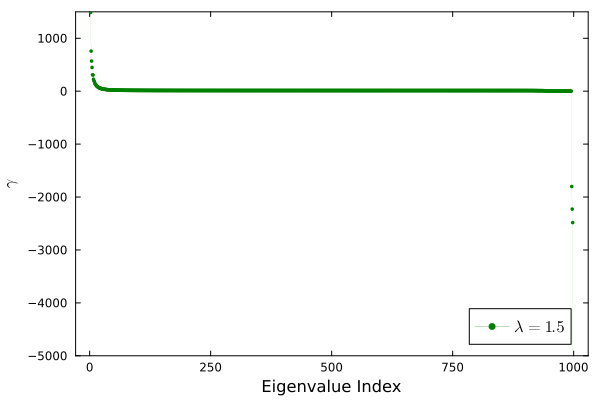

In [28]:
# plot( - real( f1["Eigs_Real"] ) ./ (1e4*f1["g"]), 
#     shape=:circle, ms=8, mc=:green, msc=:green, msw=2, lw=0, linestyle=:solid, linecolor=:green,
#     tickfont=font(17,"Computer Modern"), guidefont = font(20,"Computer Modern"), 
#     framestyle = :box, grid = false, 
#     label=latexstring("\$ \\lambda = $( round(1.478; digits=3) ) \$"), legendfont=(15,"Computer Modern"),
#     topmargin=2mm, leftmargin=2mm, bottommargin=3mm, rightmargin=2mm )

# plot!( - real( f2["Eigs_Real"] ) ./ (1e4*f2["g"]), 
#     shape=:xcross, ms=6, mc=:red, msc=:red, msw=2, lw=1, linestyle=:solid, linecolor=:red,
#     tickfont=font(17,"Computer Modern"), guidefont = font(20,"Computer Modern"), 
#     framestyle = :box, grid = false, 
#     label=latexstring("\$ \\lambda = $( round(1.479; digits=3) ) \$"), legendfont=(15,"Computer Modern"),
#     topmargin=2mm, leftmargin=2mm, bottommargin=3mm, rightmargin=2mm )

plot( -real( Eigs_Real ), 
    shape=:circle, ms=2, mc=:green, msc=:green, lw=0, linestyle=:solid, linecolor=:green,
    framestyle = :box, grid = false,
    label=latexstring("\$ \\lambda = $( round(sum(λ_List); digits=3) ) \$"), legendfont=(11,"Computer Modern"), titlefont = font(10,"Computer Modern") )

# title!("Comparing the spectrum after the phase transition for " * L"T = 0.20g")

# xlims!( r/2, L-r/2 )
# xlims!( 890, L )
ylims!( -5000, 1500 )

xlabel!( "Eigenvalue Index" )
ylabel!( L"\gamma" )
# ylabel!( L"\widetilde{\gamma}" )

In [96]:
savefig("Multiple_Phonon_Results/EigenSpectrum.pdf")

"/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/Linear_Stability_Codes/Multiple_Phonon_Results/EigenSpectrum.pdf"

### **Magnified Plot**

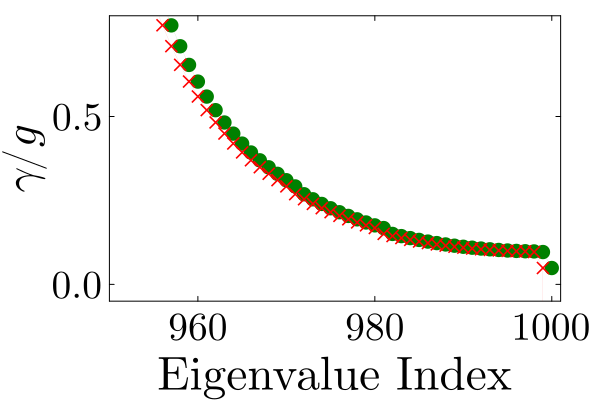

In [99]:
plot( - real( f1["Eigs_Real"] ) ./ (f1["g"]), 
    shape=:circle, ms=8, mc=:green, msc=:green, msw=2, lw=0, linestyle=:solid, linecolor=:green,
    tickfont=font(25,"Computer Modern"), guidefont = font(30,"Computer Modern"), 
    framestyle = :box, grid = false, legend=false, 
    # label=latexstring("\$ \\lambda = $( round(1.478; digits=3) ) \$"), legendfont=(14,"Computer Modern"),
    topmargin=2mm, leftmargin=2mm, bottommargin=5mm, rightmargin=8mm )

plot!( - real( f2["Eigs_Real"] ) ./ (f2["g"]), 
    shape=:xcross, ms=6, mc=:red, msc=:red, msw=2, lw=0, linestyle=:solid, linecolor=:red,
    tickfont=font(25,"Computer Modern"), guidefont = font(30,"Computer Modern"), 
    framestyle = :box, grid = false, legend=false, 
    # label=latexstring("\$ \\lambda = $( round(1.479; digits=3) ) \$"), legendfont=(14,"Computer Modern"),
    topmargin=2mm, leftmargin=2mm, bottommargin=5mm, rightmargin=8mm )

# plot!( real( Eigs_Real ), 
#     shape=:circle, ms=2, mc=:green, msc=:green, lw=0, linestyle=:solid, linecolor=:green,
#     framestyle = :box, grid = false,
#     label=latexstring("\$ \\lambda = $( round(sum(λ_List); digits=3) ) \$"), legendfont=(11,"Computer Modern"), titlefont = font(10,"Computer Modern") )

# title!("Comparing the spectrum after the phase transition for " * L"T = 0.20g")

# xlims!( r/2, L-r/2 )
xlims!( 950, 1001 )
ylims!( -0.05, 0.8 )

xlabel!( "Eigenvalue Index" )
ylabel!( L"\gamma/g" )

Xt = collect(range(960, 1000, step=20));
# Xt = collect(range(0, 2, step=1));
Yt = collect(range( 0.0, 1.0, step=0.5));
# Yt = collect(range( -0.3, 0.6, step=0.3));
# Yt = collect(range( -0.1, 0.1, step=0.1));

xticks!(Xt, string.( Int.( Xt ) ))
yticks!(Yt, string.( round.( Yt, digits=2 ) ))

In [100]:
savefig("Multiple_Phonon_Results/EigenSpectrumMag.pdf")

"/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/Linear_Stability_Codes/Multiple_Phonon_Results/EigenSpectrumMag.pdf"

## **Plot the eigenvector that loses stability**

### **Find the relevant index**

In [17]:
# N_of_Eigvec = find_closest( F.values, 1/λJmax )

# N_of_Eigvec = find_closest( F.values, 1/EigsJ_n_max[2] )

### **Plot**

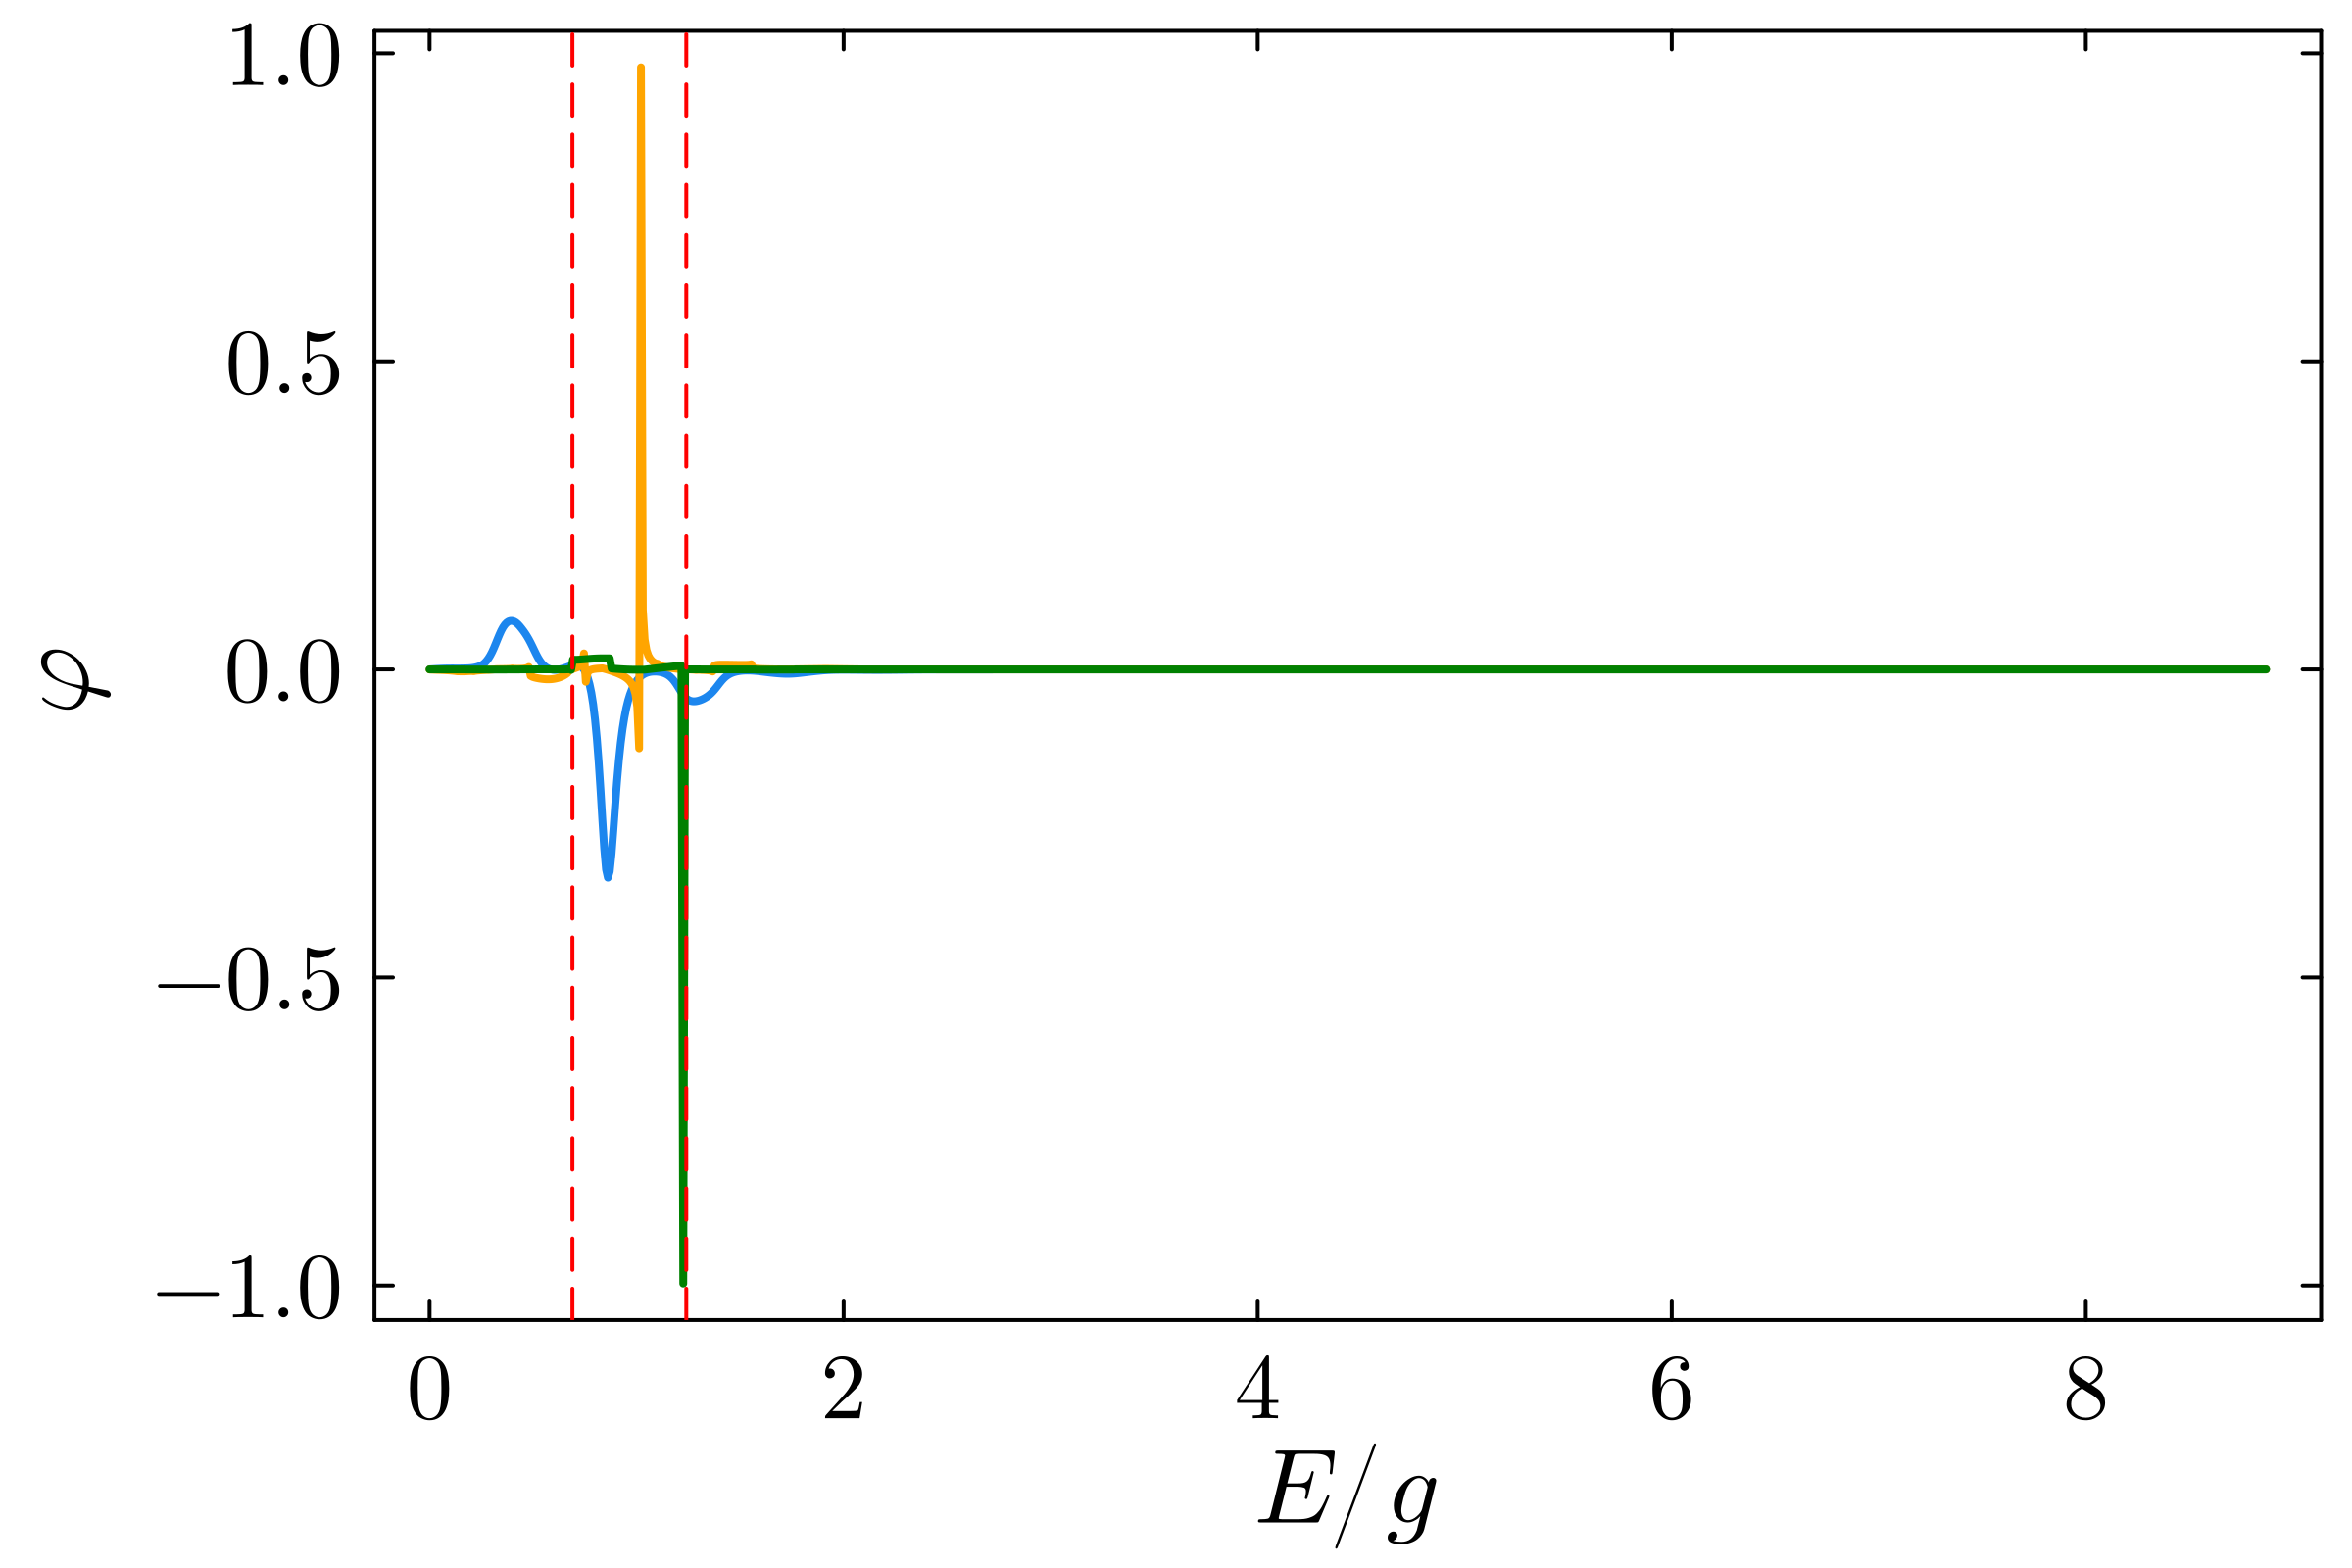

In [48]:
### Plot the corresponding eigenvector ###

N1_US_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Positive[1] );  # Absolute value smallest. Most delocalized. 
N2_US_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Positive[31] );
N3_US_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Positive[62] ); # Absolute value is largest. Most localized.

N1_S_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Negative[938] ); # Absolute value is smallest. Most delocalized.
N2_S_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Negative[469] );
N3_S_of_Eigvec = find_closest( F.values, 1.0/Eigs_Real_Negative[1] );   # Absolute value is largest. Most localized. 

E_Range = range(start=0, step=(ΔE/g), length=L);

# yMin = minimum(F.vectors[:,N_of_Eigvec])-0.1; 
# yMax = maximum(F.vectors[:,N_of_Eigvec])+0.1;

# yMin = -0.1; 
# yMax = 0.1;

# ######################################################################################################################    
#                                             ### Stable Eigenvectors ###
# ######################################################################################################################

# plot( E_Range, F.vectors[:,(N1_S_of_Eigvec)], 
#     lw=2, linestyle=:solid, linecolor=:dodgerblue2,
#     tickfont=font(15,"Computer Modern"), guidefont = font(18,"Computer Modern"), 
#     framestyle = :box, grid = false, legend=:false, dpi = 400,
#     topmargin=0mm, leftmargin=2mm, bottommargin=2mm, rightmargin=0mm )

# plot!( E_Range, F.vectors[:,(N2_S_of_Eigvec)], 
#     lw=2, linestyle=:solid, linecolor=:orange,
#     tickfont=font(15,"Computer Modern"), guidefont = font(18,"Computer Modern"), 
#     framestyle = :box, grid = false, legend=:false, dpi = 400,
#     topmargin=0mm, leftmargin=2mm, bottommargin=2mm, rightmargin=0mm )

# plot!( E_Range, F.vectors[:,(N3_S_of_Eigvec)], 
#     lw=2, linestyle=:solid, linecolor=:green,
#     tickfont=font(15,"Computer Modern"), guidefont = font(18,"Computer Modern"), 
#     framestyle = :box, grid = false, legend=:false, dpi = 400,
#     topmargin=0mm, leftmargin=2mm, bottommargin=2mm, rightmargin=0mm )

# ######################################################################################################################    
# ######################################################################################################################
# ######################################################################################################################

######################################################################################################################    
                                            ### Unstable Eigenvectors ###
######################################################################################################################

plot( E_Range, F.vectors[:,(N1_US_of_Eigvec)], 
    lw=2, linestyle=:solid, linecolor=:dodgerblue2,
    tickfont=font(15,"Computer Modern"), guidefont = font(18,"Computer Modern"), 
    framestyle = :box, grid = false, legend=:false, dpi = 400,
    topmargin=0mm, leftmargin=2mm, bottommargin=2mm, rightmargin=0mm )

plot!( E_Range, F.vectors[:,(N2_US_of_Eigvec)], 
    lw=2, linestyle=:solid, linecolor=:orange,
    tickfont=font(15,"Computer Modern"), guidefont = font(18,"Computer Modern"), 
    framestyle = :box, grid = false, legend=:false, dpi = 400,
    topmargin=0mm, leftmargin=2mm, bottommargin=2mm, rightmargin=0mm )

plot!( E_Range, F.vectors[:,(N3_US_of_Eigvec)], 
    lw=2, linestyle=:solid, linecolor=:green,
    tickfont=font(15,"Computer Modern"), guidefont = font(18,"Computer Modern"), 
    framestyle = :box, grid = false, legend=:false, dpi = 400,
    topmargin=0mm, leftmargin=2mm, bottommargin=2mm, rightmargin=0mm )

######################################################################################################################    
######################################################################################################################
######################################################################################################################

E_Z_0_min1 = 0.69; 
plot!([E_Z_0_min1], seriestype="vline", dpi = 400,
    lw=1, linestyle=:dash, linecolor=:red)

E_Z_0_min2 = 1.24; 
plot!([E_Z_0_min2], seriestype="vline", dpi = 400,
        lw=1, linestyle=:dash, linecolor=:red)

xlabel!( L"E/g")
ylabel!( L"\varphi" )
# ylabel!( L"\varphi_\textrm{max}(E/g)" )
# ylabel!( L"\varphi_{\textrm{max} - 1}(E/g)" )

# xlims!( 0, (L-1)*(ΔE/g) )
# xlims!( 0, 2 )
# ylims!( yMin, yMax )
# ylims!( -0.1, 0.1 )

# Xt = collect(range(0, 4, step=1));
# Xt = collect(range(0, 2, step=1));
# Yt = collect(range( -1.0, 1.0, step=0.5));
# Yt = collect(range( -0.3, 0.6, step=0.3));
# Yt = collect(range( -0.1, 0.1, step=0.1));

# xticks!(Xt, string.( Int.( Xt ) ))
# xticks!(Xt, ["0", "", "2", "", "4"])
# yticks!(Yt, string.( round.( Yt, digits=2 ) ))

In [49]:
# savefig("Multiple_Phonon_Results/StableEigenVecs.png")

savefig("Multiple_Phonon_Results/UnstableEigenVecs.png")

"/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/Linear_Stability_Codes/Multiple_Phonon_Results/UnstableEigenVecs.png"

## **Compare direct diagonalization and generalized eigenvalues**

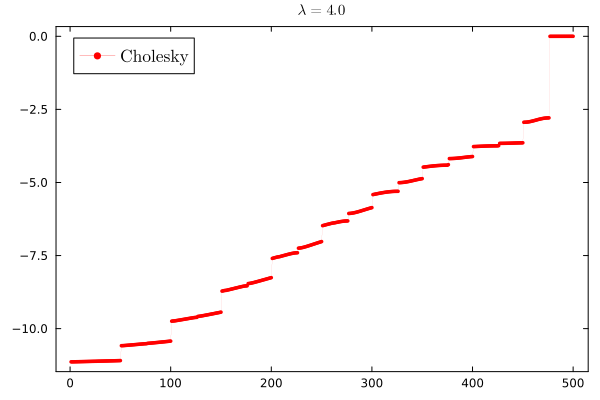

In [102]:
# plot( real( Eigs_Real ), 
#     shape=:circle, ms=2, mc=:black, msc=:black, lw=0, linestyle=:solid, linecolor=:black,
#     framestyle = :box, grid = false,
#     label="Direct", legendfont=(10,"Computer Modern"), titlefont = font(10,"Computer Modern") )

plot( real( Eigs_Real ), 
    shape=:circle, ms=2, mc=:red, msc=:red, lw=0, linestyle=:solid, linecolor=:red,
    framestyle = :box, grid = false,
    label="Cholesky", legendfont=(11,"Computer Modern"), titlefont = font(10,"Computer Modern") )

# plot!( real( Eigs_Real ), 
#     shape=:circle, ms=2, mc=:green, msc=:green, lw=0, linestyle=:solid, linecolor=:green,
#     framestyle = :box, grid = false )

title!(latexstring("\$ \\lambda = $( round(sum(λ_List); digits=3) ) \$"))

# xlims!( r/2, L-r/2 )
# xlims!( 890, L )
# ylims!( -1e-3, 1e-3 )

## - Important Commands:

### - To find out whether a matrix is symmetric: issymmetric()

### - To find out whether a matrix is diagonal: isdiag()

### - To find out the indices of $Q$ that are "non-symmetric": findall(!iszero, Q_Mat - Q_Mat')

# **Iteration to obtain $\lambda_\textrm{critical}$**

## **List of temperatures and corresponding $\lambda_\textrm{critical}$**

In [24]:
N_τ0    = 10;

τ0_Range = (0.18:(0.29-0.18)/(N_τ0-1):0.29);            # τ = T0/g

τ0_Range = round.( τ0_Range; digits=3 )

10-element Vector{Float64}:
 0.18
 0.192
 0.204
 0.217
 0.229
 0.241
 0.253
 0.266
 0.278
 0.29

In [38]:
# Ω_Critical_List_LS_1Ph  = [0.960, 0.872, 0.796, 0.717, 0.641, 0.570, 0.489, 0.401, 0.303, 0.143];

# λ_Critical_List_LS_51Ph = [  ];

In [39]:
# Ω_Critical_List_Z0_1Ph  = [0.962, 0.873, 0.797, 0.718, 0.642, 0.571, 0.490, 0.402, 0.304, 0.144];

# λ_Critical_List_Z0_51Ph = [  ];

## **Linear Analysis**

In [16]:
######################################################################################################################
                    ### Define the Parameters. We choose to do it for different L manually. ### 
######################################################################################################################

L                           = 1000;                            # Related to the cut-off of the energy 

r_Left                      = 40;                             # Minimum Phonon frequency
r_Right                     = 60;                             # Maximum Phonon frequency  
N_Phonon                    = Int( r_Right - r_Left + 1 );    # Number of phonons
r_List                      = range( Int(r_Left), step=1, stop=Int(r_Right) );  
                                                              # Multiple frequencies

ΔE                          = 0.05;                           # Keeping ΔE and Ωᵢ fixed
Ω_List                      = ΔE .* r_List;                   # Ω_List

λ                           = 1.000;                          # Initialize the electron-phonon intereaction
λ_List                      = (λ/N_Phonon) .* ones(N_Phonon); # α²F(Ω) = ∑ᵢ λᵢΩᵢ δ(Ω - Ωᵢ) 

######################################################################################################################    
######################################################################################################################
######################################################################################################################


######################################################################################################################
                                                ### Scanning over λ ### 
######################################################################################################################

Δλ                   = 1e-1;      # Choose an initial λ step

ελ_Critical          = 1e-5;      # Choose an error-bar for λ_Critical

λ_Max                = 1e2;       # This is the maximum value of the electron-phonon interaction that we consider 

Λ_List               = Float64[]; # Empty list for storing the electron-phonon interaction strengths
Scaled_Eigs_Max_List = Float64[]; # Empty list for storing the maximum eigenvalues corresponding to the specific electron-phonon interaction strengths

######################################################################################################################    
######################################################################################################################
######################################################################################################################



######################################################################################################################
                                                ### START WHILE LOOP ### 
                        ### Runs until we achieve the desired accuracy in λ_Critical or if λ > λ_Max ###
######################################################################################################################

tick()

while Δλ > (ελ_Critical) && λ < λ_Max
    


    ######################################################################################################################
                                            ### Defining the temperature. It depends on λ. ###
                                        ### This needs to be updated every time we update λ. ### 
                                                ### All the matrices depend on T0. ###  
    ######################################################################################################################

    g  = sqrt( sum(λ_List) * mean( Ω_List.^2 ) );        # g is now changed

    T0 = 0.20 * g;                                       # This should be higher than T_Critical for the kinetic equation to be valid

    ######################################################################################################################    
    ######################################################################################################################
    ######################################################################################################################
    
    
    
    ##################################################################################################################################################################
    ### DEFINING ALL THE MATRICES ###
    ##################################################################################################################################################################

    A_Total_Mat = zeros( L, L ); 
    Fill_A_Total!( A_Total_Mat, ΔE, L, N_Phonon, Ω_List, λ_List, T0 );


    ######################################################################################################################
    ### Define the total B ###
    ######################################################################################################################

    B_Total_Mat = zeros( L, L );

    for i = 1:N_Phonon 

        B_Int_Mat   = zeros( L, L ); 
        Fill_B!( B_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

        B_Total_Mat = B_Total_Mat + B_Int_Mat;

    end

    ######################################################################################################################
    ######################################################################################################################
    ######################################################################################################################


    ######################################################################################################################
    ### Define the total C ###
    ######################################################################################################################

    C_Total_Mat = zeros( L, L );

    for i = 1:N_Phonon 

        C_Int_Mat   = zeros( L, L ); 
        Fill_C!( C_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

        C_Total_Mat = C_Total_Mat + C_Int_Mat;

    end

    ######################################################################################################################
    ######################################################################################################################
    ######################################################################################################################


    ######################################################################################################################
    ### Define the total P ###
    ######################################################################################################################

    P_Total_Mat = zeros( L, L );

    for i = 1:N_Phonon 

        P_Int_Mat   = zeros( L, L ); 
        Fill_P!( P_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

        P_Total_Mat = P_Total_Mat + P_Int_Mat;

    end

    ######################################################################################################################
    ######################################################################################################################
    ######################################################################################################################


    ######################################################################################################################
    ### Define the total Q ###
    ######################################################################################################################

    Q_Total_Mat = zeros( L, L );

    for i = 1:N_Phonon 

        Q_Int_Mat   = zeros( L, L ); 
        Fill_Q!( Q_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

        Q_Total_Mat = Q_Total_Mat + Q_Int_Mat;

    end

    Q_Total_Mat = (1/2.0) * ( Q_Total_Mat + transpose(Q_Total_Mat) ); # Forcefully symmetrizing the total Q matrix.

    ######################################################################################################################
    ######################################################################################################################
    ######################################################################################################################


    D_Total_Mat = ( P_Total_Mat + transpose(P_Total_Mat) - Q_Total_Mat ); 


    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################



        
    ##################################################################################################################################################################
    ### Generalized eigenvalue problem: Ax = λBx. 
    ### To find λ: eigen(A, B)   
    ### The form of our problem: (C-D)φ = λ(A-B)φ
    ### We should solve for: (A-B)φ = λ^{-1}(C-D)φ, since (C-D) remains positive semidefinite.
    ### We now do the generaized diagonalization by hand.
    ### Note that: We write C-D = L.L^{T} = R^{T}.R
    ##################################################################################################################################################################

    RT                 = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=true ).L;
    R                  = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=true ).U;

    Symm_LHS           = Symmetric( inv(RT) * Symmetric( A_Total_Mat - B_Total_Mat ) * inv( R ) );

    F                  = eigen( Symm_LHS );

    Eigs_Real          = sort( 1.0 ./ real( F.values ) );
    Eigs_Max           = maximum( real( Eigs_Real ) ); # Obtaining the eigenvalue. We use the LinearAlgebra package.
    
    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################
    

    
    ##################################################################################################################################################################
    ### SAVING THE MAXIMUM EIGENVALUES FOR THE CORRESPONDING EL-PH INTERACTIONS ###
    ##################################################################################################################################################################

    push!( Λ_List, sum(λ_List) ); push!( Scaled_Eigs_Max_List, (Eigs_Max/g) );

    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################
    
    ##################################################################################################################################################################
    ### UPDATING THE ELECTRON-PHONON INTERACTION STRENGTH ###
    ##################################################################################################################################################################
    
    if Eigs_Max > ελ_Critical
        
        println("λ_Critical for T₀/g = $( T0/g ) is λ = $( round( sum(λ_List); digits=7) )");
        
        pop!(Λ_List); pop!(Scaled_Eigs_Max_List);       # Removes the last element from Λ_List and Eigs_Max_List if Eigs_Max > 0   
        
        λ     -= Δλ;                                    # After hitting the singularity, New λ = (λ_Critical at this step) - Δλ

        λ_List = (λ/N_Phonon) .* ones(N_Phonon);        # α²F(Ω) = ∑ᵢ λᵢΩᵢ δ(Ω - Ωᵢ) 
        
        Δλ    /= 10;                                    # After hitting the singularity, Δλ_New = Δλ_Old/10
        
    else
        
        println("Calculation for λ = $( round( sum(λ_List); digits=7) ) done!");
        
        λ      += Δλ;                                   # If no singularity, λ_New = λ_Old + Δλ 

        λ_List = (λ/N_Phonon) .* ones(N_Phonon);        # α²F(Ω) = ∑ᵢ λᵢΩᵢ δ(Ω - Ωᵢ)
        
    end
     
    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################
    
end

tock()

######################################################################################################################
                                                ### END WHILE LOOP ### 
                            ### Runs until we achieve the desired accuracy in Ω_Critical ###
######################################################################################################################

┌ Info:  started timer at: 2024-09-06T12:20:17.710
└ @ TickTock /Users/aniket/.julia/packages/TickTock/KFrVj/src/TickTock.jl:54


Calculation for λ = 1.0 done!
Calculation for λ = 1.1 done!
Calculation for λ = 1.2 done!
Calculation for λ = 1.3 done!
Calculation for λ = 1.4 done!
λ_Critical for T₀/g = 0.20000000000000004 is λ = 1.5
Calculation for λ = 1.4 done!
Calculation for λ = 1.41 done!
Calculation for λ = 1.42 done!
Calculation for λ = 1.43 done!
Calculation for λ = 1.44 done!
Calculation for λ = 1.45 done!
Calculation for λ = 1.46 done!
Calculation for λ = 1.47 done!
λ_Critical for T₀/g = 0.20000000000000004 is λ = 1.48
Calculation for λ = 1.47 done!
Calculation for λ = 1.471 done!
Calculation for λ = 1.472 done!
Calculation for λ = 1.473 done!
Calculation for λ = 1.474 done!
Calculation for λ = 1.475 done!
Calculation for λ = 1.476 done!
Calculation for λ = 1.477 done!
Calculation for λ = 1.478 done!
λ_Critical for T₀/g = 0.2 is λ = 1.479
Calculation for λ = 1.478 done!
Calculation for λ = 1.4781 done!
Calculation for λ = 1.4782 done!
Calculation for λ = 1.4783 done!
Calculation for λ = 1.4784 done!
Calcul

┌ Info:         28.133463917s: 28 seconds, 133 milliseconds
└ @ TickTock /Users/aniket/.julia/packages/TickTock/KFrVj/src/TickTock.jl:62


### **Plot the relaxation time**

#### **Do a linear fit**

In [53]:
perm = sortperm(Λ_List);

m(t, p) = p[1] .+ p[2]*t;
p0 = [0.5, -0.15];

fit = curve_fit(m, Λ_List[perm], Scaled_Eigs_Max_List[perm], p0);
println("Fitted parameters: ", fit.param)

Fitted parameters: [0.02178675004417823, -0.14241523353180685]


#### **Plot**

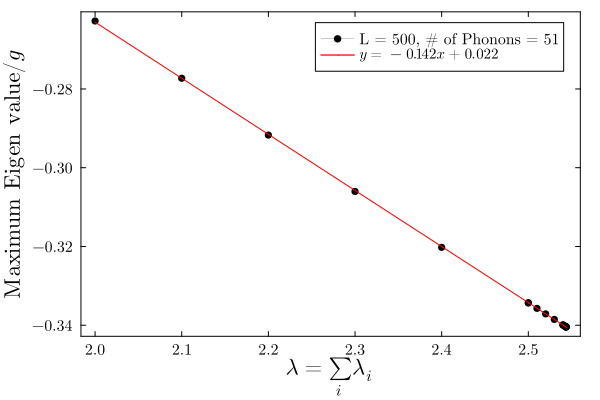

In [63]:
plot( Λ_List[perm], Scaled_Eigs_Max_List[perm],  
    shape=:circle, ms=4, mc=:black, msc=:black, lw=0, linestyle=:solid, linecolor=:black,
    framestyle = :box, grid = false,
    label="L = $( L ), # of Phonons = $( N_Phonon )", 
    legendfont=(10,"Computer Modern"), titlefont = font(10,"Computer Modern"),
    tickfont=font(10,"Computer Modern"), guidefont = font(15,"Computer Modern"),
    lefttmargin=2mm, bottommargin=2mm, rightmargin=3mm )

plot!( Λ_List[perm], fit.param[1] .+ (fit.param[2] .* Λ_List[perm]),  
    shape=:circle, ms=0, mc=:red, msc=:red, lw=1, linestyle=:solid, linecolor=:red,
    framestyle = :box, grid = false,
    label=latexstring("\$ y = -0.142x + 0.022 \$"), 
    legendfont=(10,"Computer Modern"), titlefont = font(10,"Computer Modern"),
    tickfont=font(10,"Computer Modern"), guidefont = font(15,"Computer Modern"),
    lefttmargin=2mm, bottommargin=2mm, rightmargin=3mm )

ylabel!( L"\textrm{Maximum \;\: Eigen\;\: value}/g" )
xlabel!( L"\lambda = \sum_{i} \lambda_{i}")

title!("")

# xlims!( r/2, L-r/2 )
# xlims!( 890, L )
# ylims!( -10, 0 )

In [64]:
savefig("/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/Figures/Lambda_vs_MaxEig.pdf")

"/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/Figures/Lambda_vs_MaxEig.pdf"

## **Linear Analysis: Temperature Dependence**

In [16]:
######################################################################################################################
                                        ### Initialize the lists ### 
######################################################################################################################

N_τ0                  = 10;

τ0_List               = (0.18:(0.29-0.18)/(N_τ0-1):0.29); # τ = T0/g

τ0_List               = round.( τ0_List; digits=3 );

λ_Critical_List       = zeros( length(τ0_List) );

λ_Critical_Guess_List = [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 5.0, 8.0, 21.0]; # Obtained from scanning Z_0(E)
λ_Critical_Guess_List = λ_Critical_Guess_List .- 0.1; 

######################################################################################################################    
######################################################################################################################
######################################################################################################################



######################################################################################################################
                                                ### START WHILE LOOP ### 
                        ### Runs until we achieve the desired accuracy in λ_Critical or if λ > λ_Max ###
######################################################################################################################

tick()

for tt = 1 : N_τ0



    ######################################################################################################################
                        ### Define the Parameters. We choose to do it for different L manually. ### 
    ######################################################################################################################
    
    L                           = 1000;                           # Related to the cut-off of the energy 

    r_Left                      = 40;                             # Minimum Phonon frequency
    r_Right                     = 60;                             # Maximum Phonon frequency  
    N_Phonon                    = Int( r_Right - r_Left + 1 );    # Number of phonons
    r_List                      = range( Int(r_Left), step=1, stop=Int(r_Right) );  
                                                                  # Multiple frequencies

    ΔE                          = 0.05;                           # Keeping ΔE and Ωᵢ fixed
    Ω_List                      = ΔE .* r_List;                   # Ω_List

    λ                           = λ_Critical_Guess_List[tt];      # Initialize the electron-phonon intereaction
                                                                  # Make this smaller than the smallest possible λ_Critical 
                                                                  # for all the T0 considered.
    λ_List                      = (λ/N_Phonon) .* ones(N_Phonon); # α²F(Ω) = ∑ᵢ λᵢΩᵢ δ(Ω - Ωᵢ) 
 
    ######################################################################################################################    
    ######################################################################################################################
    ######################################################################################################################


    ######################################################################################################################
                                                    ### Scanning over λ ### 
    ######################################################################################################################

    Δλ                   = 1e-1;       # Choose an initial Ω step

    ελ_Critical          = 1e-5;       # Choose an error-bar for Ω_Critical

    λ_Max                = 1e2;        # This is the maximum value of the electron-phonon interaction that we consider 

    ######################################################################################################################    
    ######################################################################################################################
    ######################################################################################################################



    while Δλ > (ελ_Critical) && λ < λ_Max
    


        ######################################################################################################################
                                                ### Defining the temperature. It depends on λ. ###
                                            ### This needs to be updated every time we update λ. ### 
                                                    ### All the matrices depend on T0. ###  
        ######################################################################################################################
    
        g  = sqrt( sum(λ_List) * mean( Ω_List.^2 ) );        # g is now changed
    
        T0 = τ0_List[tt] * g;                                # This should be higher than T_Critical for the kinetic equation to be valid
    
        ######################################################################################################################    
        ######################################################################################################################
        ######################################################################################################################
        
        
        
        ##################################################################################################################################################################
        ### DEFINING ALL THE MATRICES ###
        ##################################################################################################################################################################
    
        A_Total_Mat = zeros( L, L ); 
        Fill_A_Total!( A_Total_Mat, ΔE, L, N_Phonon, Ω_List, λ_List, T0 );
    
    
        ######################################################################################################################
        ### Define the total B ###
        ######################################################################################################################
    
        B_Total_Mat = zeros( L, L );
    
        # for i = 1:N_Phonon 
    
        #     B_Int_Mat   = zeros( L, L ); 
        #     Fill_B!( B_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );
    
        #     B_Total_Mat = B_Total_Mat + B_Int_Mat;
    
        # end
    
        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################
    
    
        ######################################################################################################################
        ### Define the total C ###
        ######################################################################################################################
    
        C_Total_Mat = zeros( L, L );
    
        for i = 1:N_Phonon 
    
            C_Int_Mat   = zeros( L, L ); 
            Fill_C!( C_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );
    
            C_Total_Mat = C_Total_Mat + C_Int_Mat;
    
        end
    
        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################
    
    
        ######################################################################################################################
        ### Define the total P ###
        ######################################################################################################################
    
        P_Total_Mat = zeros( L, L );
    
        for i = 1:N_Phonon 
    
            P_Int_Mat   = zeros( L, L ); 
            Fill_P!( P_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );
    
            P_Total_Mat = P_Total_Mat + P_Int_Mat;
    
        end
    
        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################
    
    
        ######################################################################################################################
        ### Define the total Q ###
        ######################################################################################################################
    
        Q_Total_Mat = zeros( L, L );
    
        for i = 1:N_Phonon 
    
            Q_Int_Mat   = zeros( L, L ); 
            Fill_Q!( Q_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );
    
            Q_Total_Mat = Q_Total_Mat + Q_Int_Mat;
    
        end
    
        Q_Total_Mat = (1/2.0) * ( Q_Total_Mat + transpose(Q_Total_Mat) ); # Forcefully symmetrizing the total Q matrix.
    
        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################
    
    
        D_Total_Mat = ( P_Total_Mat + transpose(P_Total_Mat) - Q_Total_Mat ); 
    
    
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################
    
    
    
            
        ##################################################################################################################################################################
        ### Generalized eigenvalue problem: Ax = λBx. 
        ### To find λ: eigen(A, B)   
        ### The form of our problem: (C-D)φ = λ(A-B)φ
        ### We should solve for: (A-B)φ = λ^{-1}(C-D)φ, since (C-D) remains positive semidefinite.
        ### We now do the generaized diagonalization by hand.
        ### Note that: We write C-D = L.L^{T} = R^{T}.R
        ##################################################################################################################################################################
    
        RT                 = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=true ).L;
        R                  = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=true ).U;
    
        Symm_LHS           = Symmetric( inv(RT) * Symmetric( A_Total_Mat - B_Total_Mat ) * inv( R ) );
    
        F                  = eigen( Symm_LHS );
    
        Eigs_Real          = sort( 1.0 ./ real( F.values ) );
        Eigs_Max           = maximum( real( Eigs_Real ) ); # Obtaining the eigenvalue. We use the LinearAlgebra package.
        
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################
    
        
                
        ##################################################################################################################################################################
        ### UPDATING THE ELECTRON-PHONON INTERACTION STRENGTH ###
        ##################################################################################################################################################################
        
        if Eigs_Max > ελ_Critical
            
            λ_Critical_List[tt] = λ;                              # Saving λ
            
            λ                  -= Δλ;                             # After hitting the singularity, New λ = (λ_Critical at this step) - Δλ

            λ_List              = (λ/N_Phonon) .* ones(N_Phonon); # α²F(Ω) = ∑ᵢ λᵢΩᵢ δ(Ω - Ωᵢ) 
        
            Δλ                 /= 10;                             # After hitting the singularity, Δλ_New = Δλ_Old/10
        
        else
            
            # println("Calculation for λ = $( round( sum(λ_List); digits=5) ) done!");
        
            λ      += Δλ;                                         # If no singularity, λ_New = λ_Old + Δλ 

            λ_List  = (λ/N_Phonon) .* ones(N_Phonon);             # α²F(Ω) = ∑ᵢ λᵢΩᵢ δ(Ω - Ωᵢ)
            
        end
        
        
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        
    end

    ######################################################################################################################
                                                    ### END WHILE LOOP ### 
                                ### Runs until we achieve the desired accuracy in Ω_Critical ###
    ######################################################################################################################
    
    println("λ_Critical for T₀/g = $( τ0_List[tt] ) with L = $( L ), r_Left = $( r_Left ), and r_Right = $( r_Right ) is $( round(λ_Critical_List[tt];digits=5) ).");

end

tock()

######################################################################################################################
                                                ### END WHILE LOOP ### 
                            ### Runs until we achieve the desired accuracy in Ω_Critical ###
######################################################################################################################

┌ Info:  started timer at: 2024-08-25T20:15:57.496
└ @ TickTock /Users/aniket/.julia/packages/TickTock/KFrVj/src/TickTock.jl:54


λ_Critical for T₀/g = 0.18 with L = 1000, r_Left = 40, and r_Right = 60 is 1.1335.
λ_Critical for T₀/g = 0.192 with L = 1000, r_Left = 40, and r_Right = 60 is 1.3262.
λ_Critical for T₀/g = 0.204 with L = 1000, r_Left = 40, and r_Right = 60 is 1.5644.
λ_Critical for T₀/g = 0.217 with L = 1000, r_Left = 40, and r_Right = 60 is 1.8991.
λ_Critical for T₀/g = 0.229 with L = 1000, r_Left = 40, and r_Right = 60 is 2.3097.
λ_Critical for T₀/g = 0.241 with L = 1000, r_Left = 40, and r_Right = 60 is 2.8822.
λ_Critical for T₀/g = 0.253 with L = 1000, r_Left = 40, and r_Right = 60 is 3.7428.
λ_Critical for T₀/g = 0.266 with L = 1000, r_Left = 40, and r_Right = 60 is 5.3642.
λ_Critical for T₀/g = 0.278 with L = 1000, r_Left = 40, and r_Right = 60 is 8.6521.
λ_Critical for T₀/g = 0.29 with L = 1000, r_Left = 40, and r_Right = 60 is 21.1356.


┌ Info:        103.133033083s: 1 minute, 43 seconds, 133 milliseconds
└ @ TickTock /Users/aniket/.julia/packages/TickTock/KFrVj/src/TickTock.jl:62


## **Linear Analysis: System-Size Dependence**

### <span style = "color:red">**NEED TO FIX.**</span>

In [61]:
######################################################################################################################
                                        ### Initialize the lists ### 
######################################################################################################################

L_List            = (100:100:1000);                            # Related to the cut-off of the energy 

# r_List_0          = Int.( (10/100) .* (100:100:1000) );        # Ω = r * ΔE
r_List_P          = Int.( (12/100)  .* (100:100:1000) );        # Ω = r * ΔE
# r_List_M          = Int.( (8/100) .* (100:100:1000) );        # Ω = r * ΔE

# Ω_Critical_List_0 = zeros( length(L_List) );
Ω_Critical_List_P = zeros( length(L_List) );
# Ω_Critical_List_M = zeros( length(L_List) );

######################################################################################################################    
######################################################################################################################
######################################################################################################################



######################################################################################################################
                                                ### START WHILE LOOP ### 
                            ### Runs until we achieve the desired accuracy in Ω_Critical ###
######################################################################################################################

tick()

for j = 1 : length(L_List)



    ######################################################################################################################
                        ### Define the Parameters. We choose to do it for different L manually. ### 
    ######################################################################################################################

    L  = L_List[j];      # Here we choose L and r from the given lists

    # r  = r_List_0[j];    # Here we choose L and r from the given lists
    r  = r_List_P[j];    # Here we choose L and r from the given lists
    # r  = r_List_M[j];    # Here we choose L and r from the given lists

    ΔE = 0.9/r; 

    Ω  = r * ΔE; 

    T0 = 0.20;           # We keep it fixed to 0.20

    ######################################################################################################################    
    ######################################################################################################################
    ######################################################################################################################


    ######################################################################################################################
                                                    ### Scanning over Ω ### 
    ######################################################################################################################

    ΔΩ          = 1e-1;  # Choose an initial Ω step

    εΩ_Critical = 1e-4;  # Choose an error-bar for Ω_Critical

    ######################################################################################################################    
    ######################################################################################################################
    ######################################################################################################################



    while ΔΩ > (εΩ_Critical) && Ω > 0 
        
        
        
        ##################################################################################################################################################################
        ### DEFINING ALL THE MATRICES ###
        ##################################################################################################################################################################

        A_Mat = zeros( L, L ); 
        Fill_A!( A_Mat, L, r, Ω, T0 );

        B_Mat = zeros( L, L ); 
        Fill_B!( B_Mat, L, r, Ω, T0 );

        C_Mat = zeros( L, L ); 
        Fill_C!( C_Mat, L, r, Ω, T0 );

        P_Mat = zeros( L, L );
        Fill_P!( P_Mat, L, r, Ω, T0 );

        Q_Mat = zeros( L, L );
        Fill_Q!( Q_Mat, L, r, Ω, T0 );
        Q_Mat = (1/2.0) * ( Q_Mat + transpose(Q_Mat) ); # Forcefully symmetrizing the Q matrix. 

        D_Mat = P_Mat + transpose(P_Mat) - Q_Mat;        # Define the D matrix

        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        
        
            
        ##################################################################################################################################################################
        ### FIND THE MAXIMUM EIGENVALUE OF (A-B)^(-1) * (C-D) ###
        ##################################################################################################################################################################

        J  = inv( A_Mat - B_Mat ) * ( C_Mat - D_Mat );
        
        λJ = maximum( real( eigvals( J ) ) );            # Obtaining the eigenvalue. We use the LinearAlgebra package.
        
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        
        
        
        ##################################################################################################################################################################
        ### UPDATING Ω ###
        ##################################################################################################################################################################

        
        if λJ > 1e-4
            
            # Ω_Critical_List_0[j] = Ω;      # Saving Ω
            Ω_Critical_List_P[j] = Ω;      # Saving Ω
            # Ω_Critical_List_M[j] = Ω;      # Saving Ω
            
            Ω                    += ΔΩ;    # After hitting the singularity, New Ω = (Ω_Critical at this step) + ΔΩ
            
            ΔΩ                   /= 10;    # After hitting the singularity, ΔΩ_New = ΔΩ_Old/10
            
            ΔE                   = Ω / r;  # Update ΔE
        
        else
            
            # println("Calculation for $( round(Ω;digits=3) ) done!");
            
            Ω                    -= ΔΩ;    # If no singularity, Ω_New = Ω_Old - ΔΩ 
            
            ΔE                   = Ω / r;  # Update ΔE
            
        end
        
        
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        
    end

    ######################################################################################################################
                                                    ### END WHILE LOOP ### 
                                ### Runs until we achieve the desired accuracy in Ω_Critical ###
    ######################################################################################################################
    
    # println("Ω_Critical for T₀ = $( T0 ), L = $( L ) and r = $( r ) is $( round(Ω_Critical_List_0[j];digits=3) ). λ_Critical is $( round( 1/(Ω_Critical_List_0[j]^2);digits=3) )");
    println("Ω_Critical for T₀ = $( T0 ), L = $( L ) and r = $( r ) is $( round(Ω_Critical_List_P[j];digits=3) ). λ_Critical is $( round( 1/(Ω_Critical_List_P[j]^2);digits=3) )");
    # println("Ω_Critical for T₀ = $( T0 ), L = $( L ) and r = $( r ) is $( round(Ω_Critical_List_M[j];digits=3) ). λ_Critical is $( round( 1/(Ω_Critical_List_M[j]^2);digits=3) )");

end

tock()

######################################################################################################################
                                                ### END WHILE LOOP ### 
                            ### Runs until we achieve the desired accuracy in Ω_Critical ###
######################################################################################################################

Ω_Critical for T₀ = 0.2, L = 100 and r = 12 is 0.882. λ_Critical is 1.285


┌ Info:  started timer at: 2024-06-28T18:49:59.679
└ @ TickTock /Users/aniket/.julia/packages/TickTock/KFrVj/src/TickTock.jl:54


Ω_Critical for T₀ = 0.2, L = 200 and r = 24 is 0.885. λ_Critical is 1.277
Ω_Critical for T₀ = 0.2, L = 300 and r = 36 is 0.886. λ_Critical is 1.274
Ω_Critical for T₀ = 0.2, L = 400 and r = 48 is 0.886. λ_Critical is 1.274
Ω_Critical for T₀ = 0.2, L = 500 and r = 60 is 0.886. λ_Critical is 1.274
Ω_Critical for T₀ = 0.2, L = 600 and r = 72 is 0.886. λ_Critical is 1.274
Ω_Critical for T₀ = 0.2, L = 700 and r = 84 is 0.886. λ_Critical is 1.274
Ω_Critical for T₀ = 0.2, L = 800 and r = 96 is 0.886. λ_Critical is 1.274
Ω_Critical for T₀ = 0.2, L = 900 and r = 108 is 0.886. λ_Critical is 1.274
Ω_Critical for T₀ = 0.2, L = 1000 and r = 120 is 0.886. λ_Critical is 1.274


┌ Info:          13.93082625s: 13 seconds, 930 milliseconds
└ @ TickTock /Users/aniket/.julia/packages/TickTock/KFrVj/src/TickTock.jl:62


In [62]:
@save "Lin_Stab_Lr_Depend.jld2" Ω_Critical_List_0 Ω_Critical_List_P Ω_Critical_List_M;

# **Plot of $Z_0$ vs $E$ for a particular $T_0$ and $\Omega$**

## <span style = "color:red">**NEED TO FIX.**</span>

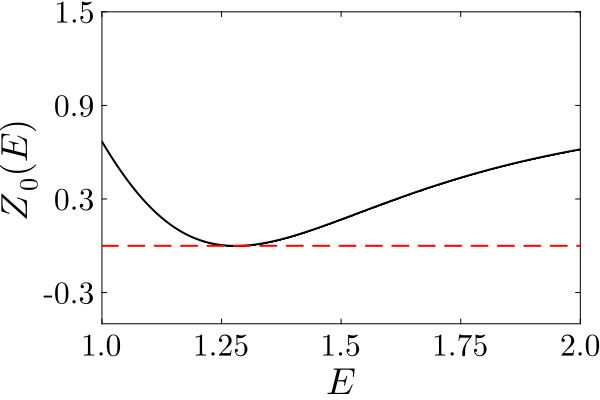

In [136]:
N_Phonon = Int(2);                # Number of phonons

r₁       = Int(L/10);             # We keep L/r₁ = 10.

r_List   = [r₁, 1];               # Ω = r * ΔE 

ΔE       = 0.886/r_List[1]; 

Ω_List   = ΔE .* r_List;          # Ω_List

λ₁       = 1/(Ω_List[1]^2);       # The value of λ corresponding to Ω₁

λ_List   = λ₁ .* [1.0, 1e-4];     # Recall that g² = λΩ². We fix λ₂/λ₁ = 1e-4. 

T0       = 0.20;                  # This should be higher than T_Critical for the kinetic equation to be valid

E_left  = 1.0;
E_right = 2.0;

E_Range = E_left:1e-3:E_right;


Z0_List = zeros( length(E_Range) );
for i = 1:length(E_Range)
    Z0_List[i] = Z0( E_Range[i], N_Phonon, Ω_List, λ_List, T0 );
end

plot( E_Range, Z0_List,  
    shape=:circle, ms=0, mc=:black, msc=:black, lw=2, linestyle=:solid, linecolor=:black,
    tickfont=font(20,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
    guidefont = font(25,"Computer Modern"), legendfont=(11,"Computer Modern"),
    framestyle = :box, grid = false, legend=false,
    lefttmargin=2mm, bottommargin=2mm, rightmargin=3mm )

Z_0_0 = 0;

plot!([(E_left - 0.05), (E_right + 0.05)], [Z_0_0, Z_0_0],
      lw=2, linestyle=:dash, linecolor=:red )

# title!(L"\Omega_{c}"* " vs " * L"N")

# ylabel!( L"\{ f_\textrm{k}(t) \} \equiv \{ u_\textrm{k}(t) \}" )
ylabel!( L"Z_{0}(E)" )
xlabel!( L"E")

xlims!( E_left, E_right )
ylims!( -0.5, 1.5 )

Xt = collect(range(E_left,E_right,step=0.25));
Yt = collect(range(-0.3,1.5,step=0.6));

xticks!(Xt, string.( round.( Xt, digits=2 ) ))
yticks!(Yt, string.( round.( Yt, digits=1 ) ))

In [36]:
savefig("/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/IDA_Codes/Solutions_V2/Stable_Z0.pdf")

"/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/IDA_Codes/Solutions_V2/Stable_Z0.pdf"

# **Plot of $\lambda_{*}(T_0 = 0.20)$ vs $N$**

## **Loading the file**

In [63]:
@load "Lin_Stab_Lr_Depend.jld2" Ω_Critical_List_0 Ω_Critical_List_P Ω_Critical_List_M;

## **Plot**

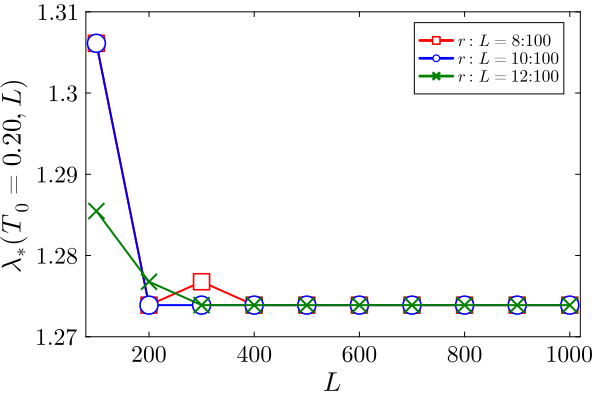

In [78]:
plot( (100:100:1000), 1.0 ./ (Ω_Critical_List_M .^2),  
    shape=:rect, ms=8, mc=:white, msc=:red, msw=2, lw=2, linestyle=:solid, linecolor=:red,
    tickfont=font(15,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
    guidefont = font(18,"Computer Modern"), legendfont=(11,"Computer Modern"),
    framestyle = :box, grid = false, label=L"r:L = "*"8:100", legend=:topright,
    lefttmargin=2mm, bottommargin=2mm, rightmargin=3mm )

plot!( (100:100:1000), 1.0 ./ (Ω_Critical_List_0 .^2),  
    shape=:circle, ms=10, mc=:white, msc=:blue, msw=2, lw=2, linestyle=:solid, linecolor=:blue,
    tickfont=font(15,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
    guidefont = font(18,"Computer Modern"), legendfont=(11,"Computer Modern"),
    framestyle = :box, grid = false, label=L"r:L = "*"10:100", legend=:topright,
    lefttmargin=2mm, bottommargin=2mm, rightmargin=3mm )

plot!( (100:100:1000), 1.0 ./ (Ω_Critical_List_P .^2),  
    shape=:xcross, ms=8, mc=:green, msc=:green, msw=2, lw=2, linestyle=:solid, linecolor=:green,
    tickfont=font(15,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
    guidefont = font(18,"Computer Modern"), legendfont=(11,"Computer Modern"),
    framestyle = :box, grid = false, label=L"r:L = "*"12:100", legend=:topright,
    lefttmargin=2mm, bottommargin=2mm, rightmargin=3mm )

# title!(L"\Omega_{c}"* " vs " * L"N")

# ylabel!( L"\{ f_\textrm{k}(t) \} \equiv \{ u_\textrm{k}(t) \}" )
ylabel!( L"\lambda_{*}(T_0 = 0.20, L)" )
xlabel!( L"L")

xlims!( 1e2-20, 1e3+20 )
ylims!( 1.27, 1.31 )

Xt = collect(range(200,  1020, step=200));
Yt = collect(range(1.27, 1.31, step=0.01));

xticks!(Xt, string.( Int.( Xt ) ))
yticks!(Yt, string.( round.( Yt, digits=3 ) ))

In [79]:
savefig("/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/Figures/Lambda_T_N_vs_N.pdf")

"/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/Figures/Lambda_T_N_vs_N.pdf"

# **Analyze the maximum eigenvalues across criticality**

## <span style = "color:red">**NO NEED TO FIX.**</span>

In [66]:
######################################################################################################################
                    ### Define the Parameters. We choose to do it for different L manually. ### 
######################################################################################################################

L                           = 1000;                           # Related to the cut-off of the energy 

r_Left                      = 40;                             # Minimum Phonon frequency
r_Right                     = 60;                             # Maximum Phonon frequency  
N_Phonon                    = Int( r_Right - r_Left + 1 );    # Number of phonons
r_List                      = range( Int(r_Left), step=1, stop=Int(r_Right) );  
                                                              # Multiple frequencies

ΔE                          = 0.05;                           # Keeping ΔE and Ωᵢ fixed
Ω_List                      = ΔE .* r_List;                   # Ω_List
 
######################################################################################################################    
######################################################################################################################
######################################################################################################################



######################################################################################################################
                                                ### Scanning over λ ### 
######################################################################################################################

λ_Critical           = 1.4788;                                   # The critical λ for for the 

Δλ                   = 1e-2;                                     # Choose an initial Ω step

λ_Min                = λ_Critical - 50*Δλ;                      # Choose the minimum λ

λ_Max                = λ_Critical + 50*Δλ;                      # This is the maximum value of the electron-phonon interaction that we consider

Λ_Scan_List          = range(start=λ_Min, step=Δλ, stop=λ_Max ); # Now build the λ_List

Eigs_Real_Mat        = zeros(Float64, length(Λ_Scan_List), L);   # Matrix that saves all the eigenvalues in unit of g. 
                                                                 # [Eigs_Real_Mat]_{ij} = Eigs_Real_j(λ_{i}). 
                                                                 # Number of rows = number of λ values that we consider = length(Λ_Scan_List). 
                                                                 # Number of columns = Number of eigenvalues = L.

Scaled_Eigs_Max_List = Float64[];                                # Empty list for storing the maximum eigenvalues corresponding to the specific electron-phonon interaction strengths

######################################################################################################################    
######################################################################################################################
######################################################################################################################


tick()

for j = 1:length(Λ_Scan_List) 



        ######################################################################################################################
                                                ### Defining the temperature. It depends on λ. ###
                                                ### This needs to be updated every time we update λ. ### 
                                                        ### All the matrices depend on T0. ###  
        ######################################################################################################################

        λ      = Λ_Scan_List[j];                              # Initialize the value of λ 

        λ_List = (λ/N_Phonon) .* ones(N_Phonon);              # α²F(Ω) = ∑ᵢ λᵢΩᵢ δ(Ω - Ωᵢ)

        g      = sqrt( sum(λ_List) * mean( Ω_List.^2 ) );     # g is now changed

        T0     = 0.20 * g;                                    # This should be higher than T_Critical for the kinetic equation to be valid

        ######################################################################################################################    
        ######################################################################################################################
        ######################################################################################################################
        
        
        
        ##################################################################################################################################################################
        ### DEFINING ALL THE MATRICES ###
        ##################################################################################################################################################################

        A_Total_Mat = zeros( L, L ); 
        Fill_A_Total!( A_Total_Mat, ΔE, L, N_Phonon, Ω_List, λ_List, T0 );


        ######################################################################################################################
        ### Define the total B ###
        ######################################################################################################################

        B_Total_Mat = zeros( L, L );

        for i = 1:N_Phonon 

                B_Int_Mat   = zeros( L, L ); 
                Fill_B!( B_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

                B_Total_Mat = B_Total_Mat + B_Int_Mat;

        end

        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################


        ######################################################################################################################
        ### Define the total C ###
        ######################################################################################################################

        C_Total_Mat = zeros( L, L );

        for i = 1:N_Phonon 

                C_Int_Mat   = zeros( L, L ); 
                Fill_C!( C_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

                C_Total_Mat = C_Total_Mat + C_Int_Mat;

        end

        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################


        ######################################################################################################################
        ### Define the total P ###
        ######################################################################################################################

        P_Total_Mat = zeros( L, L );

        for i = 1:N_Phonon 

                P_Int_Mat   = zeros( L, L ); 
                Fill_P!( P_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

                P_Total_Mat = P_Total_Mat + P_Int_Mat;

        end

        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################


        ######################################################################################################################
        ### Define the total Q ###
        ######################################################################################################################

        Q_Total_Mat = zeros( L, L );

        for i = 1:N_Phonon 

                Q_Int_Mat   = zeros( L, L ); 
                Fill_Q!( Q_Int_Mat, ΔE, L, r_List[i], Ω_List[i], λ_List[i], T0 );

                Q_Total_Mat = Q_Total_Mat + Q_Int_Mat;

        end

        Q_Total_Mat = (1/2.0) * ( Q_Total_Mat + transpose(Q_Total_Mat) ); # Forcefully symmetrizing the total Q matrix.

        ######################################################################################################################
        ######################################################################################################################
        ######################################################################################################################


        D_Total_Mat = ( P_Total_Mat + transpose(P_Total_Mat) - Q_Total_Mat ); 


        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################



                
        ##################################################################################################################################################################
        ### Generalized eigenvalue problem: Ax = λBx. 
        ### To find λ: eigen(A, B)   
        ### The form of our problem: (C-D)φ = λ(A-B)φ
        ### We should solve for: (A-B)φ = λ^{-1}(C-D)φ, since (C-D) remains positive semidefinite.
        ### We now do the generaized diagonalization by hand.
        ### Note that: We write C-D = L.L^{T} = R^{T}.R
        ##################################################################################################################################################################

        RT                 = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=true ).L;
        R                  = cholesky( Symmetric( C_Total_Mat - D_Total_Mat ); check=true ).U;

        Symm_LHS           = Symmetric( inv(RT) * Symmetric( A_Total_Mat - B_Total_Mat ) * inv( R ) );

        F                  = eigen( Symm_LHS );

        Eigs_Real          = sort( 1.0 ./ real( F.values ) );
        Eigs_Max           = maximum( real( Eigs_Real ) ); # Obtaining the eigenvalue. We use the LinearAlgebra package.

        println("The maximum eigenvalue at T0 = $( T0/g ) at ∑ᵢλᵢ = $( λ ) is $( Eigs_Max/g ).");
        println("Energy and temperatures are given in the units of g = $( g )");
        
        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################



        ##################################################################################################################################################################
        ### SAVING THE MAXIMUM EIGENVALUES FOR THE CORRESPONDING EL-PH INTERACTIONS ###
        ### SAVING ALL THE EIGENVALUES FOR THE CORRESPONDING EL-PH INTERACTIONS ###
        ##################################################################################################################################################################

        push!( Scaled_Eigs_Max_List, (Eigs_Max/g) ); # Saving the maximum eigenvalue

        Eigs_Real_Mat[j,:] = real( Eigs_Real ) ./ g; # Saving all the eigenvalues for a specific λ as a new row

        ##################################################################################################################################################################
        ##################################################################################################################################################################
        ##################################################################################################################################################################



end

tock()

┌ Info:  started timer at: 2024-09-08T23:08:03.013
└ @ TickTock /Users/aniket/.julia/packages/TickTock/KFrVj/src/TickTock.jl:54


The maximum eigenvalue at T0 = 0.2 at ∑ᵢλᵢ = 0.9787999999999999 is -0.0227490294726184.
Energy and temperatures are given in the units of g = 2.491429977609913
The maximum eigenvalue at T0 = 0.2 at ∑ᵢλᵢ = 0.9887999999999999 is -0.023233841831169142.
Energy and temperatures are given in the units of g = 2.504124597539028
The maximum eigenvalue at T0 = 0.2 at ∑ᵢλᵢ = 0.9987999999999999 is -0.02372090828358072.
Energy and temperatures are given in the units of g = 2.5167551860812103
The maximum eigenvalue at T0 = 0.2 at ∑ᵢλᵢ = 1.0088 is -0.024210161882399443.
Energy and temperatures are given in the units of g = 2.5293227024903984
The maximum eigenvalue at T0 = 0.19999999999999998 at ∑ᵢλᵢ = 1.0188 is -0.024701537489253453.
Energy and temperatures are given in the units of g = 2.5418280823061186
The maximum eigenvalue at T0 = 0.20000000000000004 at ∑ᵢλᵢ = 1.0288 is -0.025194971732805348.
Energy and temperatures are given in the units of g = 2.554272238166219
The maximum eigenvalue at T0 = 0

┌ Info:         77.904339916s: 1 minute, 17 seconds, 904 milliseconds
└ @ TickTock /Users/aniket/.julia/packages/TickTock/KFrVj/src/TickTock.jl:62


In [67]:
@save "Multiple_Phonon_Results/eigenvalues_$(L)_rM_$(r_Left)_rP_$(r_Right)_T0_$(T0/g)_Del_E_$(ΔE)"*".jld2" λ_Critical Δλ λ_Min λ_Max Λ_Scan_List g Eigs_Real_Mat Scaled_Eigs_Max_List;

## **Plotting the eigenvalues vs $\lambda$**

### **Normal plot**

In [89]:
@load "Multiple_Phonon_Results/eigenvalues_1000_rM_40_rP_60_T0_0.2_Del_E_0.05.jld2" λ_Critical Δλ λ_Min λ_Max Λ_Scan_List g Eigs_Real_Mat Scaled_Eigs_Max_List;

function SaveEigenSpectrum( λ_Critical, Δλ, λ_Min, λ_Max, Λ_Scan_List, g, Eigs_Real_Mat, Scaled_Eigs_Max_List ) 

    # plot( 
    #     (Λ_Scan_List .- λ_Critical) ./ Δλ, Scaled_Eigs_Max_List ./ 1e5,
    #     shape=:circle, ms=4, mc=:white, msc=:black, msw=2, lw=2, linestyle=:solid, linecolor=:black, 
    #     tickfont=font(15,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
    #     guidefont = font(18,"Computer Modern"), legendfont=(11,"Computer Modern"),
    #     framestyle = :box, grid = false, legend=:false,
    #     topmargin=5mm, leftmargin=5mm, bottommargin=5mm, rightmargin=5mm );
    #
    # plot( 
    #     ((Λ_Scan_List .- λ_Critical) ./ Δλ)[1:20], Scaled_Eigs_Max_List[1:20],
    #     shape=:circle, ms=8, mc=:white, msc=:black, msw=4, lw=4, linestyle=:solid, linecolor=:black,
    #     tickfont=font(30,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
    #     guidefont = font(40,"Computer Modern"), legendfont=(11,"Computer Modern"),
    #     framestyle = :box, grid = false, legend=:false,
    #     topmargin=5mm, lefttmargin=5mm, bottommargin=5mm, rightmargin=5mm );

    # shape=:xcross, ms=4, mc=:green, msc=:green, msw=2,

    scatter( 
        Λ_Scan_List, - Eigs_Real_Mat[:,1] ./ (1e3*pi),
        shape=:circle, ms=2, mc=:black, msc=:black, msw=2, 
        tickfont=font(15,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
        guidefont = font(18,"Computer Modern"), legendfont=(11,"Computer Modern"),
        framestyle = :box, grid = false, legend=:false, dpi=400,
        topmargin=5mm, leftmargin=5mm, bottommargin=5mm, rightmargin=5mm );

    for i = 2:1:L

        scatter!( 
            Λ_Scan_List, - Eigs_Real_Mat[:,i] ./ (1e3*pi),
            shape=:circle, ms=2, mc=:black, msc=:black, msw=2, 
            tickfont=font(15,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
            framestyle = :box, grid = false, legend=:false, dpi=400,
            topmargin=5mm, leftmargin=5mm, bottommargin=5mm, rightmargin=5mm );

    end

    # shape=:star5, ms=4, mc=:red, msc=:red, msw=2,

    # scatter!( 
    #     Λ_Scan_List, - Eigs_Real_Mat[:,L],
    #     shape=:circle, ms=2, mc=:black, msc=:black, msw=2, 
    #     tickfont=font(15,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
    #     guidefont = font(18,"Computer Modern"), legendfont=(11,"Computer Modern"),
    #     framestyle = :box, grid = false, legend=:false,
    #     topmargin=5mm, leftmargin=5mm, bottommargin=5mm, rightmargin=5mm );

    # title!( latexstring("\$ \\Delta\\lambda = $( round(Δλ; digits=6) ) \$") )

    #########################################################################################################################################################################################
    #########################################################################################################################################################################################
    #########################################################################################################################################################################################

    # ms_main = 3; msw_main = 1; lw_main = 1; tcsf_main = 17; gdf_main = 20; 

    # plot( 
    #     (f["Λ_Scan_List"] .- f["λ_Critical"]) ./ f["Δλ"], - f["Eigs_Real_Mat"][:,1]./( maximum(abs.(f["Eigs_Real_Mat"][:,1])) ),
    #     shape=:xcross, ms=ms_main, mc=:green, msc=:green, msw=msw_main, lw=lw_main, linestyle=:solid, linecolor=:green, 
    #     tickfont=font(tcsf_main,"Computer Modern"), guidefont = font(gdf_main,"Computer Modern"), 
    #     framestyle = :box, grid = false, legend=:false,
    #     topmargin=5mm, leftmargin=5mm, bottommargin=5mm, rightmargin=5mm );

    # for i = 2:1:(L-1)

    #     plot!( 
    #         (f["Λ_Scan_List"] .- f["λ_Critical"]) ./ f["Δλ"], - f["Eigs_Real_Mat"][:,i]./( maximum(abs.(f["Eigs_Real_Mat"][:,i])) ),
    #         shape=:circle, ms=ms_main, mc=:black, msc=:black, msw=msw_main, lw=lw_main, linestyle=:solid, linecolor=:black, 
    #         tickfont=font(tcsf_main,"Computer Modern"), guidefont = font(gdf_main,"Computer Modern"), 
    #         framestyle = :box, grid = false, legend=:false,
    #         topmargin=5mm, leftmargin=5mm, bottommargin=5mm, rightmargin=5mm );

    # end

    # plot!( 
    #     (f["Λ_Scan_List"] .- f["λ_Critical"]) ./ f["Δλ"], - f["Eigs_Real_Mat"][:,L]./( maximum(abs.(f["Eigs_Real_Mat"][:,L])) ),
    #     shape=:star5, ms=ms_main+1, mc=:red, msc=:red, msw=msw_main, lw=lw_main, linestyle=:solid, linecolor=:red,
    #     tickfont=font(tcsf_main,"Computer Modern"), guidefont = font(gdf_main,"Computer Modern"), 
    #     framestyle = :box, grid = false, legend=:false,
    #     topmargin=5mm, leftmargin=5mm, bottommargin=5mm, rightmargin=5mm );

    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################

    # Eig0 = 0;

    # ymin = -1e4; ymax = 1e4;

    plot!([1.4788], seriestype="vline", dpi=400,
          lw=2, linestyle=:dash, linecolor=:red )

    # plot!([0], seriestype="hline",
    #       lw=1, linestyle=:dash, linecolor=:green )

    # xlabel!( L"\lambda")
    # ylabel!( L"\gamma/g" )
    # ylabel!( L"\gamma_\textrm{max}/g" )

    xlims!( 1.0,  1.6 )
    # xlims!( -21,  0 )
    ylims!( -1e0, 1e0 )
    # ylims!( -0.34045, -0.34015 )

    Xt = collect(range(1.1,  1.6, step=0.2));
    # Xt = collect(range(-20,  0, step=10));
    # Yt = collect(range( 0, 4.5, step=1));
    Yt = collect(range( -1e0, 1e0, step=0.5));

    xticks!(Xt, string.( round.( Xt, digits=1 ) ))
    yticks!(Yt, string.( round.( Yt, digits=2 ) ))

    savefig("Multiple_Phonon_Results/EigenSpectrum_Lam_Scan_Raw_ChosenYAxis.png")

end

SaveEigenSpectrum( λ_Critical, Δλ, λ_Min, λ_Max, Λ_Scan_List, g, Eigs_Real_Mat, Scaled_Eigs_Max_List )

"/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/Linear_Stability_Codes/Multiple_Phonon_Results/EigenSpectrum_Lam_Scan_Raw_ChosenYAxis.png"

### **Magnified plot**

In [90]:
@load "Multiple_Phonon_Results/eigenvalues_1000_rM_40_rP_60_T0_0.2_Del_E_0.05.jld2" λ_Critical Δλ λ_Min λ_Max Λ_Scan_List g Eigs_Real_Mat Scaled_Eigs_Max_List;

function SaveEigenSpectrum_Mag( λ_Critical, Δλ, λ_Min, λ_Max, Λ_Scan_List, g, Eigs_Real_Mat, Scaled_Eigs_Max_List ) 



    scatter( 
        Λ_Scan_List, - Eigs_Real_Mat[:,1] ./ pi,
        shape=:circle, ms=2, mc=:black, msc=:black, msw=2, 
        tickfont=font(25,"Computer Modern"), titlefont = font(20,"Computer Modern"), 
        guidefont = font(30,"Computer Modern"), legendfont=(11,"Computer Modern"),
        framestyle = :box, grid = false, legend=:false, dpi = 400,
        topmargin=5mm, leftmargin=5mm, bottommargin=5mm, rightmargin=5mm );

    for i = 2:1:L

        scatter!( 
            Λ_Scan_List, - Eigs_Real_Mat[:,i] ./ pi,
            shape=:circle, ms=2, mc=:black, msc=:black, msw=2, 
            tickfont=font(25,"Computer Modern"), titlefont = font(30,"Computer Modern"), 
            framestyle = :box, grid = false, legend=:false, dpi = 400,
            topmargin=5mm, leftmargin=5mm, bottommargin=5mm, rightmargin=5mm );



    end

    
    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################



    plot!([1.4788], seriestype="vline", dpi = 400,
          lw=2, linestyle=:dash, linecolor=:red )

    plot!([0], seriestype="hline", dpi = 400,
          lw=2, linestyle=:solid, linecolor=:green )

    # xlabel!( L"\lambda")
    # ylabel!( L"\gamma/g" )
    # ylabel!( L"\gamma_\textrm{max}/g" )

    xlims!( 1.0,  1.6 )
    ylims!( -0.05, 0.05 )

    Xt = collect(range(1.1,  1.6, step=0.2));
    Yt = collect(range( -0.05, 0.05, step=0.05));

    xticks!(Xt, string.( round.( Xt, digits=1 ) ))
    yticks!(Yt, string.( round.( Yt, digits=3 ) ))

    savefig("Multiple_Phonon_Results/EigenSpectrum_Lam_Scan_Raw_ChosenYAxis_Mag.png")

end

SaveEigenSpectrum_Mag( λ_Critical, Δλ, λ_Min, λ_Max, Λ_Scan_List, g, Eigs_Real_Mat, Scaled_Eigs_Max_List )

"/Users/aniket/Library/CloudStorage/Dropbox/PCS_IBS/Computation/EAY_BLA_Partial_Differential_Eqn/Linear_Stability_Codes/Multiple_Phonon_Results/EigenSpectrum_Lam_Scan_Raw_ChosenYAxis_Mag.png"